<a href="https://colab.research.google.com/github/saso-gatto/Yashi-Game/blob/main/KN_YashiGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yashi Game**

Project for "Knowledge Representation and Learning" course at University of Padua.

Salvatore Gatto, 2044587


**The Game**

An instance of the Yashi game is specifid by a n × n integer grid for some n > 2, on which p > 2 nodes are placed. A solution of the game consists in drawing horizontal and vertical segments, satisfying the following conditions:
1. No two segments cross each other.
2. The segments form a tree, i.e., they form a graph without cycles. Put differently
still, for every two nodes a and b there is exactly one path between a and b

**Rules in details**

In Yashi Games, you can connect any two dots by using a single horizontal or single vertical line. You cannot use any diagonal lines or curved lines, and you cannot connect two dots with a path that has angles or corners. No L-shapes, no Z-shapes, just single straight lines. Each dot may be connected to 1, 2, 3 or 4 other dots, either horizontally, vertically or both. Your lines cannot cross each other, and they cannot pass through other dots, or go on top of other lines.

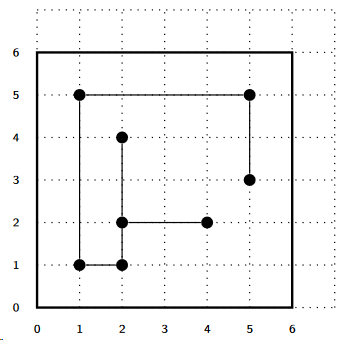


**SAT PROJECT**

Given an instance G of Yashi, develop a SAT based method to answer the following questions:
1. Decide if there is a solution for G. If there is, return one solution.
2. Decide if there is a solution for G. If there is, return a minimum-length solution.

Idea: riprodurre un sistema di assi cartesiani X,Y.

In [122]:
!pip install python-sat

In [123]:
from pysat.formula import WCNF,CNF
from pysat.solvers import Minisat22
from pysat.examples.fm import FM

from itertools import chain
from collections import defaultdict, deque
from io import StringIO
from typing import List, Set, Dict, NewType, Tuple
import random
import math
import matplotlib.pyplot as plt

In [124]:
class Point:
  def __init__ (self, x:float, y:float):
    self.x = x
    self.y =y

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def set_x(self, x:float):
    self.x = x

  def set_y(self, y:float):
    self.y = y

  def __repr__(self):
    return "("+str(self.x)+","+str(self.y)+")"

  def __str__(self) -> str:
    return "("+str(self.x)+","+str(self.y)+")"

  def __eq__(self, other):
    if isinstance(other, Point):
      return self.x == other.x and self.y == other.y
    return False

In [125]:
class Line:
  def __init__(self,p1,p2):
    self.p1 = p1
    self.p2 = p2

  def get_p1(self):
    return self.p1

  def get_p2(self):
    return self.p2

  def set_p1 (self,p):
    self.p1 = p

  def set_p2 (self,p):
    self.p2 = p

  def print(self):
    print(f"{self.p1} ----- {self.p2}")

  def __repr__(self):
    return "("+str(self.p1)+","+str(self.p2)+")"

  def __str__(self) -> str:
    return "("+str(self.p1)+","+str(self.p2)+")"



# **Graph**

By following the explaination contained on the [paper](https://www.cs.bu.edu/faculty/kfoury/UNI-Teaching/CS512/AK_Documents/Modeling-with-PL/main.pdf) provided by the professor, my idea is to build a graph using the points of yashi game and check whether the following graph is connected or not.

So, let's first create a class Graph, and then a method to check this property.
The best way to represent a graph is to use the adjacency matrix.

**Graph data structure**


We implemented a class Graph in the following way:
* self.V: list of vertices of the graph.
* self.E: dictionary representing the edges of the graph. The keys of the dictionary are the tuples of the adjacent nodes (v1,v2) and the values are the respective weights.
* self.adjacency_list: default dictionary to represent the graph as an adjacency
list.

The class Graph also contains the following methods:
* def add_vertex(self,v): the method adds the vertex “v” to the list of vertices of the graph.
* def remove_vertex(self,v): the method removes the vertex “v” from the list of
vertices of the graph.
* def add_edge(self, source_node, destination_node, weight): the method adds
the edge (source_node, destination_node) with its weight to the dictionary
graph.E. If source_node and destination_node are not inside the list of the
vertices of the Graph, the method also updates the variable self.V. The graph is
also updated appending the new edge to the adjacency list.

* def get_edge(self,v1,v2): the method returns the weight of the edge (v1,v2) by
accessing the dictionary graph.E

In [250]:
class Graph():
  def __init__ (self):
    self.V = []
    self.E= []
    self.adjacency_list = defaultdict(list)

  def add_vertex(self,v):
    if v not in self.V:
      self.V.append(v)

  def remove_vertex (self,v):
    self.V.remove(v)

  def add_edge(self, source_node, destination_node, weight):
    # First case
    # We add the source and the destination node only if the are not already present
    if (source_node not in self.V):
      self.V.append(source_node)

    if (destination_node not in self.V):
      self.V.append(destination_node)

    # Now we can add the edge
    edge = (source_node, destination_node, weight)
    self.E.append(edge)

    # Now we update the graph
    self.adjacency_list[source_node].append((destination_node,weight))
    if (source_node != destination_node):
      self.adjacency_list[destination_node].append((source_node,weight))

  def get_vertices(self):
    return self.V

  def get_adjacency_list(self):
    return self.adjacency_list

  def get_edges(self):
    return self.E

  def get_edge(self, v1,v2):
    if((v1,v2) in self.E):
      return self.E.get((v1,v2))
    else:
      return self.E.get((v2,v1))

  def sort_edges(self):
    self.E.sort(key=lambda x:x[2])


The cell above is used to initialize the graph for Yashi Game and to plot the graph in a cartesian plane.

The method **initialize_graph** takes a list of points as input and initializes a graph based on certain conditions.

Here's a breakdown of what the method does:
1. Initialize a dictionary vertices to store the mapping between vertex indices and the corresponding points.
2. Create an instance of the Graph class to represent the graph.
3. Add vertices to the graph using the indices from the vertices dictionary.
4. Iterate over the points to determine the lines and edges of the graph:

    a. For each pair of points (source_node, destination_node) in the list, check if they form a vertical or horizontal line.

    b. If the points form a vertical or horizontal line, create a Line object between the points and check if it is the shortest edge between them.

    c. If it is the shortest edge, add the line to the lines dictionary with a unique index and add an edge to the graph between the corresponding vertices.

5. Return the initialized graph, the vertices dictionary, and the lines dictionary.

The method essentially constructs a graph based on the given points, considering only the shortest vertical or horizontal edges between the points.

It also creates a mapping between vertex indices and their respective points using the vertices dictionary.

In [251]:
# First, initialize the game putting as many lines as possible in the graph.
# In our case, we'll put lines which respect the condition of the game,
# therefore no lines in diagonal, but only vertical or horizontal.

# Method to print the edges for each vertex
def print_vertices_edges(graph,vertices):
  index_keys = graph.get_adjacency_list().keys()
  print(index_keys)
  for i in index_keys:
    linked_nodes = graph.get_adjacency_list().get(i)
    for j in range (len(linked_nodes)):
      print(f"{vertices[i]} ----- {vertices[linked_nodes[j][0]]}")
      #print(linked_nodes[j])

def plot_graph(points, lines):
  # Create a figure and axis
  fig, ax = plt.subplots()

  # Set the range of x and y values
  x_values = range(0, 11)
  y_values = range(0, 11)

  # Set the x and y axis limits with offset
  ax.set_xlim(-1, 11)
  ax.set_ylim(-1, 11)

  # Set the x and y axis labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  # Set the aspect ratio to 'equal' for a square plot
  ax.set_aspect('equal')

  # Add grid lines
  ax.set_xticks(x_values)
  ax.set_yticks(y_values)
  ax.grid(True, which='both')

  current_point=1
  for point in (points):
    # Add a point at (3, 4) with red color
    ax.scatter(point.x, point.y, color='red')
    ax.text(point.x, point.y, str(current_point), ha='right', va='bottom')
    current_point = current_point+1

  for line in (lines.values()):
    # Plot a line segment between the two points
    x1 = line.get_p1().x
    x2 = line.get_p2().x
    y1 = line.get_p1().y
    y2 = line.get_p2().y
    ax.plot([x1,x2], [y1,y2], color='blue')

  # Show the plot
  plt.show()

def initialize_graph(points):
  vertices = {}
  for index in range(len(points)):
    vertices[index+1] = points[index]

  graph = Graph()
  for i in vertices.keys():
    graph.add_vertex(i)
  lines = {}
  current_index = 1

  for i in range(len(points)):
    first_node = i+1
    source_node = points[i]
    for j in range(i+1,len(points)):
      final_node =j+1
      destination_node = points[j]
      if (source_node.x == destination_node.x and source_node.y!=destination_node.y) or (source_node.y==destination_node.y and source_node.x!=destination_node.x):
        line = Line(source_node,destination_node)
        shortest_edge = True
        for k in range(len(points)):
          if k!=i and k!=j:
            index_check_node = k+1
            check_node = points[k]
            if points[i].x == points[j].x and points[k].x == points[i].x:
              if points[i].y < points[k].y < points[j].y or points[i].y > points[k].y > points[j].y:
                shortest_edge = False
                break
            elif points[i].y == points[j].y and points[k].y == points[i].y:
              if points[i].x < points[k].x < points[j].x or points[i].x > points[k].x > points[j].x:
                shortest_edge = False
                break
      else:
        shortest_edge = False

      if shortest_edge:
        lines[current_index] = line
        current_index = current_index+1
        graph.add_edge(first_node,final_node,1)

  #print(graph.get_adjacency_list())
  #plot_graph([p for p in points],lines)
  #print(graph.get_edges())

  return graph,vertices,lines

As expressed in the the following paper [Formal Modeling with Propositional Logic (Yashi Game)](https://www.cs.bu.edu/faculty/kfoury/UNI-Teaching/CS512/AK_Documents/Modeling-with-PL/main.pdf), the game has a solution if the graph is connected. If the graph is not connected, there is no solution for Yashi Game.

For this reason, I write a method called **is_connected** to perform a Depth First Search and checks if the graph given as parameter satisfies this property.
By definition, a graph is connected if there is a path from any point to any other point in the graph.

In [252]:
def is_connected(graph):
    visited = set()  # Set to keep track of visited vertices

    def DFS_visit(vertex):
        visited.add(vertex)
        for neighbor_data in graph.get_adjacency_list()[vertex]:
            neighbor = neighbor_data[0]
            if neighbor not in visited:
                DFS_visit(neighbor)

    # Perform DFS traversal starting from an arbitrary vertex
    start_vertex = list(graph.get_vertices())[0]
    DFS_visit(start_vertex)

    #print(f"Len(Visited): {len(visited)}, len(graph.get_vertices():{len(graph.get_vertices())}")
    # If all vertices have been visited, the graph is connected
    return len(visited) == len(graph.get_vertices())

#**SAT Solver**

The setting of the problem to be solved by using SAT starts by imposing some specific constrains.
As specified in the paper, the game has a solution if it respects the following property:

1.   No crossing lines
2.   iff exactly (p−1) of the Boolean variables in X are assigned true
3.   no cycles.

My idea consists of setting as sat variables the key which represent the links between two vertices.
As expressed before, the graph is composed of vertices and edges.
Each edge represents a link for the game.
Because each vertex is a point which contains the coordinate x,y on the cartesian plane, the edges are stored in a dictionary lines.

So to recap we have a graph containing
*   as vertices the points of the game -> p1 = (x,y)
*   as edges the links of the game -> l1 = (p1,p2) -> ((x1,y1),(x2,y2))

The method initializes graph returns then a dictionary of vertices whose keys are plotted in the cartesian plane, and a dictionary of lines.

The dictionary of lines allows us to have a unique identifier for each line of the graph.

**The keys are used also to create the constraint of the sat solver.**
Using the keys, we are able to map with an integer the lines of the game, and to express which lines are allowed and which not.





[(1,1), (3,1), (3,2), (6,2), (3,6), (2,8), (8,7), (8,2), (2,5), (9,5)]


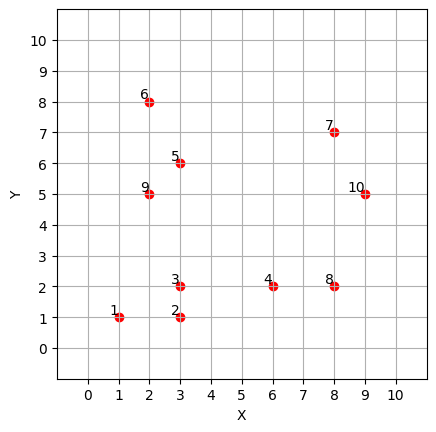

In [253]:
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (3,6)
p6 = Point (2,8)
p7 = Point (8,7)
p8 = Point (8,2)
p9 = Point (2,5)
p10 = Point(9,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
print(points)
graph,vertices,lines = initialize_graph(points)
plot_graph([p for p in points],{})

In [254]:
print(vertices.items())
print(lines.items())

dict_items([(1, (1,1)), (2, (3,1)), (3, (3,2)), (4, (6,2)), (5, (3,6)), (6, (2,8)), (7, (8,7)), (8, (8,2)), (9, (2,5)), (10, (9,5))])
dict_items([(1, ((1,1),(3,1))), (2, ((3,1),(3,2))), (3, ((3,2),(6,2))), (4, ((3,2),(3,6))), (5, ((6,2),(8,2))), (6, ((2,8),(2,5))), (7, ((8,7),(8,2))), (8, ((2,5),(9,5)))])


> **First Constraint: No Crossing Lines**

The first constraint to express with SAT is the constraint of not allowing the presence of crossing lines.

For crossing lines we mean two edges that overlaps one with the other.
Of course two horizontal links or two vertical links won't never cross one with the other because they are in parallel, therefore we have a case of crossing lines only analyzing a vertical link with an horizontal link.

The method **check_crossing_lines** takes two lines l1 and l2 as input and checks if they cross each other. It considers two cases: horizontal lines and vertical lines. For each case, it checks the coordinates of the lines to determine if there is an intersection between them. If an intersection is found, the function returns True; otherwise, it returns False.

The method **no_crossing_lines** takes a dictionary of lines as input and creates a weighted Conjunctive Normal Form (WCNF) representation of clauses.
For each pair of lines l1 and l2, the function checks if they cross each other using the check_crossing_lines function. If the lines do cross, a clause is added to the WCNF representation, combining the negation of the line variables l1_key and l2_key in the clause.

The resulting WCNF representation of clauses represents the constraint that no crossing lines are allowed. The function returns the WCNF object.

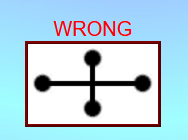

In [255]:
# Method to print the edges for each vertex
def get_edges_graph(graph,vertices):
  index_keys = graph.get_adjacency_list().keys()
  edges=[]
  print(index_keys)
  for i in index_keys:
    linked_nodes = graph.get_adjacency_list().get(i)
    for j in range (len(linked_nodes)):
      #print(f"{vertices[i]} ----- {vertices[linked_nodes[j][0]]}")
      edges.append((vertices[i],vertices[linked_nodes[j][0]]))
  return edges

In [256]:
# We get a crossin lines only when the two lines are one vertical and the other horizontal.
# Two vertical lines or two horizontal lines will never cross one each other, of course if they are parallel.
# The only thing that can happen in this case, is that the coordinates of a line can be in the middle of the other line when they have the same x or y.
# Is it this possible (?)

def check_crossing_lines(l1,l2):
  # First condition
  l1_p1 = l1.get_p1()
  l1_p2 = l1.get_p2()
  #print(l1_p1,l1_p2)

  l2_p1 = l2.get_p1()
  l2_p2 = l2.get_p2()

  # So, first we check if l1 is horizontal or vertical.
  # HORIZONTAL CASE
  if (l1_p1.get_x() == l1_p2.get_x()):
    # To be sure to check the coordinates correctly, let's set x1,x2 in such way to have x1 < x2.
    if l2_p1.get_x() < l2_p2.get_x():
      x1,x2 = l2_p1.get_x(),l2_p2.get_x()
    else:
      x1,x2 = l2_p2.get_x(),l2_p1.get_x()
    # Check that the second line is vertical!
    if (l2_p1.get_y() == l2_p2.get_y()):
      # Now there can be an intersection of the two lines, let's check the coordinates.
      if (l1_p1.get_y()<l1_p2.get_y()):
        y1,y2 = l1_p1.get_y(), l1_p2.get_y()
      else:
        y1,y2 = l1_p2.get_y(),l1_p1.get_y()
      return (l1_p1.get_x()  > x1 and l1_p1.get_x()  < x2) and (l2_p1.get_y() > y1 and l2_p1.get_y() < y2)
    # Case in which both lines are horizontal
    else:
      return False

  # VERTICAL CASE
  if (l1_p1.get_y()==l1_p2.get_y()):
    if l2_p1.get_y() < l2_p2.get_y():
      y1,y2 = l2_p1.get_y(),l2_p2.get_y()
    else:
      y1,y2 = l2_p2.get_y(),l2_p1.get_y()
    # Check that the second line is horizontal!
    if (l2_p1.get_x() == l2_p2.get_x()):
      # Again, check if there is an intersection between two lines.
      if (l1_p1.get_x()<l1_p2.get_x()):
        x1,x2 =l1_p1.get_x(),l1_p2.get_x()
      else:
        x1,x2 =l1_p2.get_x(),l1_p1.get_x()
      return (l1_p1.get_y() > y1 and l1_p1.get_y() < y2) and ( l2_p1.get_x() > x1 and l2_p1.get_x() < x2 )
    else:
      return False

def get_key(my_dict, val):
  for key, value in my_dict.items():
      if val == value:
          return key
  return "key doesn't exist"

def check_reverse_order(lst, element):
    reverse_element = [element[1], element[0]]
    return reverse_element in lst

def no_crossing_lines(lines):
  cnf = WCNF()
  clauses = []
  for l1 in lines.values():
    for l2 in lines.values():
      # If check crossing lines, it is not possible to use togheter l1 and l2,
      # Therefore we create a clauses which puts in conjunction the negation of l1 and l2.
      if check_crossing_lines(l1,l2) == True:
        l1_key = get_key(lines,l1)
        l2_key = get_key(lines,l2)
        if not check_reverse_order(clauses,[-l1_key,-l2_key]):
          #print(f"l1 is: {l1}, l1_key: {l1_key}, l2 is: {l2}, l2_key: {l2_key}")
          clauses.append([-l1_key,-l2_key])
  for c in clauses:
    cnf.append(c)
  #print(cnf.clauses)
  return cnf

In [257]:
no_crossing_lines(lines).hard

[[-4, -8], [-7, -8]]

> **SECOND CONSTRAINT**

To express the constraint "exactly k lines" I will use the formula expressed during the lesson for which it is expressed with two constrains of having at list n-k+1 lines and at most +1.

In our case, the elements to iterate are the keys of lines, where n is the number of keys.
To express the possible combination I'll use the method combinations of itertools' library.



In [258]:
import itertools

def exactly_k(literal_list,k):
  clauses = WCNF()
  n = len(literal_list)

  # at least k
  combs=list(itertools.combinations(literal_list,n-k+1))
  for sub_lists in combs:
    clauses.append(list(sub_lists))

  # at most k
  combs = list (itertools.combinations(literal_list,k+1))
  for sub_lists in combs:
    temp = [-i for i in list(sub_lists)]
    clauses.append(temp)

  return clauses

In [259]:
k = (len(points)-1)
exactly_k(lines.keys(),k)

WCNF(from_string="p wcnf 0 1 1\n1  0\n")

> **Third Constraint: no cycles**

The third constraint to set is the no presence of cycles on the final solution provided by the SAT Solver.

To provide this constraint, the method **all cycles** is in charge of finding all possible cycles of the graph given as parameter to it.
The function uses a depth-first search (DFS) approach to traverse the graph and find all cycles present in it. It employs recursion and backtracking to explore different paths and identify cycles.

The method follows the following steps:
1. It first initializes an empty list called cycles to store the cycles found in the graph.
2. The function defines an inner function called get_cycles that will be used to find the cycles.
This function will be called later to retrieve the final list of cycles.
3. The get_cycles function starts by iterating over each edge in the graph. For each edge, it iterates over the nodes of the edge and calls another inner function called findNewCycles with the node as the starting point. The findNewCycles function is responsible for finding cycles starting from a given node.
4. The findNewCycles function takes a path as input, which represents the current path being explored. It starts by setting the starting node of the path and initializes some variables.
5. It then iterates over each edge in the graph and checks if the starting node is present in the edge. If the starting node is found, it determines the next node in the edge that is not the starting node. If the next node is not already visited (not present in the current path), it extends the path with the next node and recursively calls findNewCycles with the extended path.
6. If the next node is already visited and it is the same as the first node in the path (indicating a cycle), it checks the length of the path to ensure it is longer than 2 (to avoid self-loops) and appends the path to the cycles list if it is a new cycle.
7. The function includes some helper functions like invert, rotate_to_smallest, isNew, and visited to manipulate and check the paths and cycles.
8. After finding all cycles, the get_cycles function converts the cycles into a more convenient format by converting the nodes to integers, in particular to the keys of the corrispective lines. It then returns the final list of cycles.
9. Finally, the all_cycles function calls the get_cycles function and returns the list of cycles found in the graph.


The method **create_constraint_edges** is used later to create a clause containing the lines which creates a cycle.
So for each cycle, it iterates the vertices inside of it, and for every two vertices, it set as clause the key of the line between the two vertices.


In [453]:
def get_key_lines(lines, val):
  for key, value in lines.items():
      if val.get_p1() == value.get_p1() and val.get_p2() == value.get_p2() or val.get_p1() == value.get_p2() and val.get_p2() == value.get_p1():
          return key
  return "key doesn't exist"

def all_cycles(graph):
  edges = [[t[0], t[1]] for t in graph.get_edges()]
  cycles = []

  def get_cycles():
      for edge in edges:
          for node in edge:
              findNewCycles([node])
      final_cycles= []
      current_index=0
      for cy in cycles:
          path = [(int(node)) for node in cy]
          current_index = current_index+1
          final_cycles.append(path)
      #print(final_cycles)
      return final_cycles

  # The method expects as parameter a list containt the path of the cycle.
  def findNewCycles(path):
      start_node = path[0]
      next_node= None
      sub = []

      #visit each edge and each node of each edge
      for edge in edges:
          node1, node2 = edge
          if start_node in edge:
                  if node1 == start_node:
                      next_node = node2
                  else:
                      next_node = node1
                  if not visited(next_node, path):
                          # neighbor node not on path yet
                          sub = [next_node]
                          sub.extend(path)
                          # explore extended path
                          findNewCycles(sub);
                  elif len(path) > 2  and next_node == path[-1]:
                          # cycle found
                          p = rotate_to_smallest(path);
                          inv = invert(p)
                          p.append(p[0])
                          if isNew(p) and isNew(inv):
                            cycles.append(p)

  def invert(path):
      return rotate_to_smallest(path[::-1])

  #  rotate cycle path such that it begins with the smallest node
  def rotate_to_smallest(path):
      n = path.index(min(path))
      return path[n:]+path[:n]

  def isNew(path):
      return not path in cycles

  def visited(node, path):
      return node in path

  return get_cycles()


third_constraint = all_cycles(graph)

def create_constraint_edges(arr,vertices,lines):
    constraint_edges = []
    for i in range(len(arr) - 1):
        #print(f"Current vertices: {vertices[arr[i]], vertices[arr[i+1]]})")
        line = Line(vertices[arr[i]],vertices[arr[i+1]])
        key_line = -get_key_lines(lines,line)
        #print(f"Key line is: {key_line}")
        constraint_edges.append(key_line)

    return constraint_edges

# **First Point**

*   Decide if there is a solution for G. If there is, return one solution.

The method **find_solution** checks first if the graph is connected.
If the graph is not connected, the game has not a solution, so the execution of the method ends here.

If the graph is connected instead, the method goes ahead and it creates a set of clauses (cnf) to represent the constraints of the problem. Then it adds to the cnf the 3 constraint expressed before and it appends the final set of clauses to the solver.
The solver calls the method solve to find a solution.

If a solution is found, it retrieves the model from the solver and extracts the lines corresponding to positive variables in the model. It stores the lines in the model_lines dictionary.
It calls the plot_graph function with points and model_lines to visualize the solution.

If no solution is found, it prints "No solution".

In [389]:
def find_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # If the graph is connected, then we can find a solution.
  if (is_connected(graph)):

    # Set of Clauses
    cnf = WCNF()

    # First contraint
    first_contraint = no_crossing_lines(lines)
    cnf.extend(first_contraint.hard)

    # Second constraint
    k = len(points) - 1
    second_constraint = exactly_k(lines.keys(),k)
    cnf.extend(second_constraint.hard)

    # Third constraint
    cycles = all_cycles(graph)
    third_constraint=WCNF()
    # The cycles are represented as the digit of the vertices of the plot.
    # The method create_constraint_edges converts those identifiers in the key of the line of two points
    for elem in cycles:
      third_constraint.append(create_constraint_edges(elem,vertices,lines))
    print(third_constraint.hard)
    cnf.extend(third_constraint.hard)

    #print(f"Clauses: {cnf.hard}")

    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      model = solver.get_model()
      model_lines = {x: lines[x] for x in model if x > 0}
      #print(f"Model is: {model}")
      #print(f"Model_lines: {model_lines}")
      plot_graph(points,model_lines)
    else:
      print("No solution")
  else:
    print("No solution")

# **Second Point**

* Decide if there is a solution for G. If there is, return the number of solutions.

The method **get_number_solution** for the second point works as before, with the main difference that the solver calls the method **eunm.models()** to count how many solutions are found.

I defined also a method **plot_all_solution** to plot all the different solution which are found by the solver.

In [390]:
def get_number_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # If the graph is connected, then we can find a solution.
  if (is_connected(graph)):

    # Set of Clauses
    cnf = WCNF()

    # First contraint
    first_contraint = no_crossing_lines(lines)
    cnf.extend(first_contraint.hard)

    # Second constraint
    k = len(points) - 1
    second_constraint = exactly_k(lines.keys(),k)
    cnf.extend(second_constraint.hard)

    # Third constraint
    cycles = all_cycles(graph)
    third_constraint=WCNF()
    # The cycles are represented as the digit of the vertices of the plot.
    # The method create_constraint_edges converts those identifiers in the key of the line of two points
    for elem in cycles:
      third_constraint.append(create_constraint_edges(elem,vertices,lines))
    print(third_constraint.hard)
    cnf.extend(third_constraint.hard)

    print(f"Clauses: {cnf.hard}")

    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      n_sol = 0
      for _ in solver.enum_models():
        n_sol += 1
      print("Number of solutions: ", n_sol)
    else:
      print("No solution")
  else:
    print("No solution")

# Method to plot all possible solutions
def plot_all_solutions(graph,lines,points,vertices):
  solver = Minisat22()

  # If the graph is connected, then we can find a solution.
  if (is_connected(graph)):

    # Set of Clauses
    cnf = WCNF()

    # First contraint
    first_contraint = no_crossing_lines(lines)
    cnf.extend(first_contraint.hard)

    # Second constraint
    k = len(points) - 1
    second_constraint = exactly_k(lines.keys(),k)
    cnf.extend(second_constraint.hard)

    # Third constraint
    cycles = all_cycles(graph)
    third_constraint=WCNF()
    # The cycles are represented as the digit of the vertices of the plot.
    # The method create_constraint_edges converts those identifiers in the key of the line of two points
    for elem in cycles:
      third_constraint.append(create_constraint_edges(elem,vertices,lines))
    print(third_constraint.hard)

    cnf.extend(third_constraint.hard)

    print(f"Clauses: {cnf.hard}")

    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      n_sol = 0
      for model in solver.enum_models():
        n_sol += 1
        model_lines = {x: lines[x] for x in model if x > 0}
        #print(f"Model is: {model}")
        #print(f"Model_lines: {model_lines}")
        plot_graph(points,model_lines)
      print("Number of solutions: ", n_sol)

    else:
      print("No solution")
  else:
    print("No solution")

# **Third Point**

* Decide if there is a solution for G. If there
is, return a minimum-length solution.

In this case, to find a minimum-length solution I set as weight of the constraint the euclidean distance between the two points of the links.

So, given two points p1,p2 with (x1,y1) and (x2,y2) as coordinate, the euclidean distance is computed as: .

The method **euclidian_distance(p1, p2)** calculates the Euclidean distance between two points p1 and p2 using their x and y coordinates.

The method **get_minimum_lenght_constraint(lines)** creates a weighted MaxSAT constraint for the minimum length. It iterates over each line in the lines dictionary and calculates the Euclidean distance between the line's endpoints.
It appends a soft clause to the formulas object with the key of the line as a positive literal and the negative weight equal to the negative distance. The resulting formulas object contains the soft clauses representing the minimum length constraint.

The method **get_minimum_lenght_solution(graph, lines, points, vertices)** extends the find_solution function to include the minimum length constraint. It constructs the initial clauses for the problem (first, second, and third constraints) as before. Then, it calls get_minimum_lenght_constraint to obtain the minimum length constraint as a WCNF object. It extends the clauses of cnf with the soft clauses from the minimum length constraint and their associated weights.
It initializes the solver as a FM (Weighted MaxSAT) solver with the updated cnf formula. It computes the solution using solver.compute().

If a solution is found, it retrieves the model from the solver and extracts the lines corresponding to positive variables in the model. It calculates the cost of the solution by summing the negative weights of the soft clauses and adding the solver's cost. Finally, it prints the cost of the solution and calls plot_graph to visualize the solution. If no solution is found or the graph is not connected, it prints "No solution".

In [391]:
def euclidian_distance(p1, p2):
    x1 = p1.get_x()
    x2 = p2.get_x()
    y1 = p1.get_y()
    y2 = p2.get_y()
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [392]:
def get_minimum_lenght_constraint(lines):
  formulas = WCNF()
  for line in lines.values():
    peso = euclidian_distance(line.get_p1(),line.get_p2())
    formulas.append([get_key_lines(lines,line)],weight=-peso)
    #print(euclidian_distance(line.get_p1(),line.get_p2()))
    #print(get_key_lines(lines,line))
  #print(formulas.soft)
  return formulas

get_minimum_lenght_constraint(lines)

WCNF(from_string="p wcnf 16 16 -53.0\n-4.0 1 0\n-6.0 2 0\n-2.0 3 0\n-4.0 4 0\n-2.0 3 0\n-8.0 6 0\n-2.0 7 0\n-2.0 8 0\n-2.0 9 0\n-2.0 10 0\n-3.0 11 0\n-2.0 12 0\n-3.0 13 0\n-2.0 14 0\n-8.0 6 0\n-2.0 16 0\n")

In [393]:
def get_minimum_lenght_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # If the graph is connected, then we can find a solution.
  if (is_connected(graph)):

    # Set of Clauses
    cnf = WCNF()

    # First contraint
    first_contraint = no_crossing_lines(lines)
    cnf.extend(first_contraint.hard)

    # Second constraint
    k = len(points) - 1
    second_constraint = exactly_k(lines.keys(),k)
    cnf.extend(second_constraint.hard)

    # Third constraint
    cycles = all_cycles(graph)
    third_constraint=WCNF()
    # The cycles are represented as the digit of the vertices of the plot.
    # The method create_constraint_edges converts those identifiers in the key of the line of two points
    for elem in cycles:
      third_constraint.append(create_constraint_edges(elem,vertices,lines))
    print(third_constraint.hard)
    cnf.extend(third_constraint.hard)

    # Fourth constraint
    minimum_lenght_constraint = get_minimum_lenght_constraint(lines)
    cnf.extend(minimum_lenght_constraint.soft,weights=minimum_lenght_constraint.wght)

    solver = FM(cnf,verbose=0)

    # SOLUTION
    solution = solver.compute()

    if solution:
      model = solver.model
      model_lines = {x: lines[x] for x in model if x > 0}
      print("Cost of the solution: ", -sum(minimum_lenght_constraint.wght) + solver.cost)
      plot_graph(points,model_lines)
    else:
      print("No solution")
  else:
    print("No solution")

# Examples

**First Example:**

Yashi Game with a cycle which has to be omitted.

In [434]:
# A vertex is an tuple of an integer which represents it and a point
# vertex v = (1,p1) -> this is what i want.
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (8,2)
p6 = Point (1,7)
p7 = Point (8,7)
p8 = Point (1,9)

points = [p1,p2,p3,p4,p5,p6,p7,p8]

graph,vertices,lines = initialize_graph(points)

In [435]:
all_cycles(graph)

[[1, 6, 7, 5, 4, 3, 2, 1], [1, 2, 3, 4, 5, 7, 6, 1]]

In [436]:
find_cycles_test(graph)

[]

[[-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]


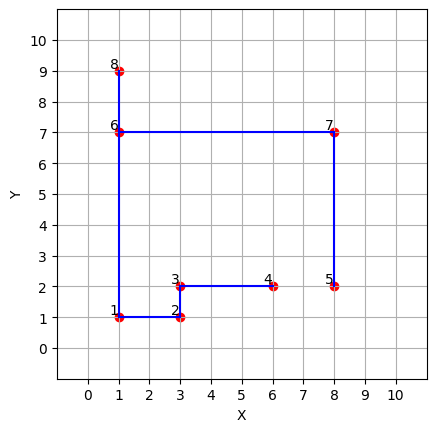

In [396]:
find_solution(graph,lines,points,vertices)

In [397]:
get_number_solution(graph,lines,points,vertices)


[[-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]
Clauses: [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8], [-1, -2, -3, -4, -5, -6, -7, -8], [-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]
Number of solutions:  7


[[-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]
Clauses: [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8], [-1, -2, -3, -4, -5, -6, -7, -8], [-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]


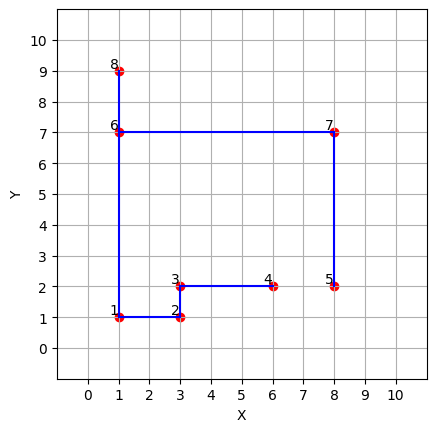

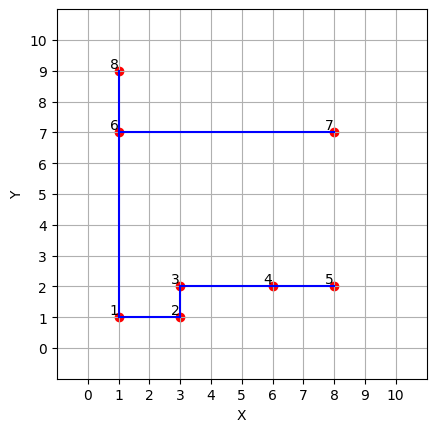

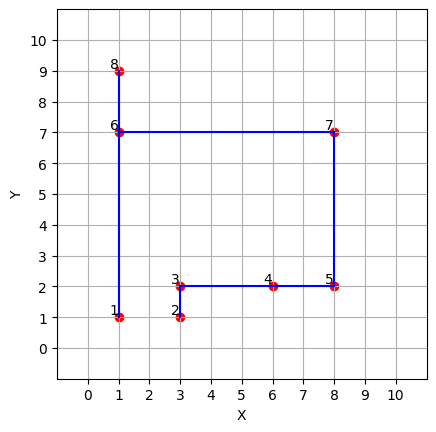

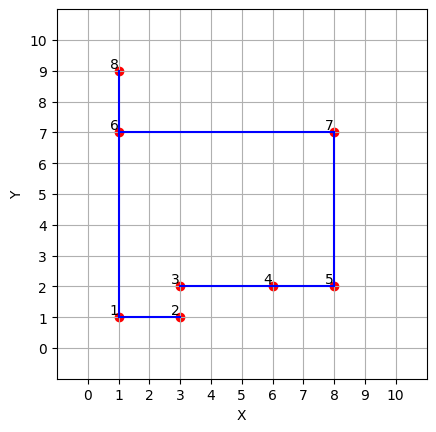

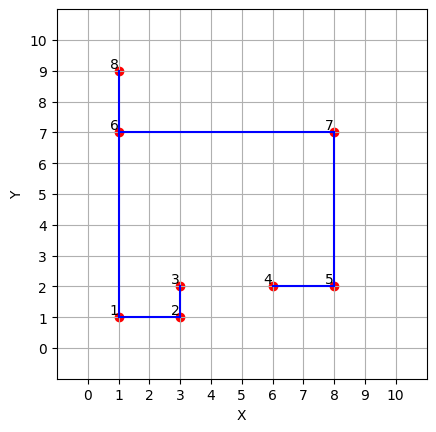

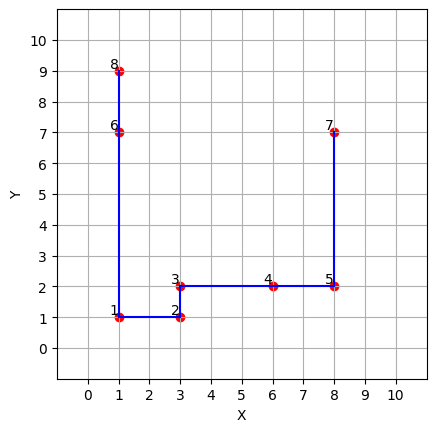

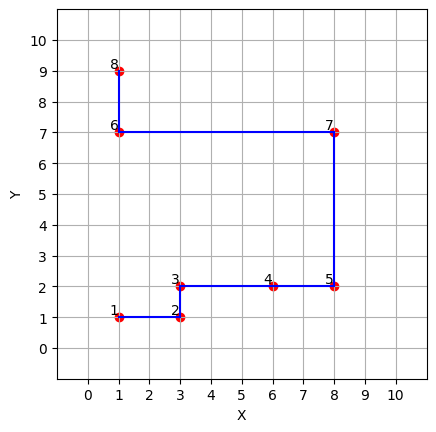

Number of solutions:  7


In [398]:
plot_all_solutions(graph,lines,points,vertices)

[[-2, -7, -6, -5, -4, -3, -1], [-1, -3, -4, -5, -6, -7, -2]]
Cost of the solution:  21.0


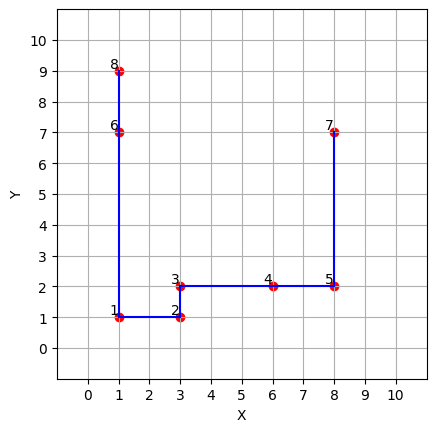

In [399]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**Second example:**

Yashi Game with crossing lines -> no possible solution in this example.

In [400]:
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (3,6)
p6 = Point (2,8)
p7 = Point (8,7)
p8 = Point (8,2)
p9 = Point (2,5)
p10 = Point(9,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
print(points)
graph,vertices,lines = initialize_graph(points)

[(1,1), (3,1), (3,2), (6,2), (3,6), (2,8), (8,7), (8,2), (2,5), (9,5)]


In [401]:
find_solution(graph,lines,points,vertices)

No solution


**Third Example**

Yashi-Game 7x7

In [402]:
p1 = Point(1,1)
p2 = Point(1,7)
p15 = Point(2,2)
p3 = Point(2,4)
p4 = Point(3,5)
p5 = Point(4,1)
p6 = Point(4,4)
p7 = Point(5,5)
p8 = Point(5,7)
p9 = Point(6,2)
p10 = Point(6,4)
p11 = Point(6,6)
p12 = Point(7,1)
p13 = Point (7,3)
p14 = Point (7,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
print(points)
graph,vertices,lines = initialize_graph(points)

[(1,1), (1,7), (2,4), (3,5), (4,1), (4,4), (5,5), (5,7), (6,2), (6,4), (6,6), (7,1), (7,3), (7,5), (2,2)]


In [403]:
print(lines.items())
all_cycles(graph)

dict_items([(1, ((1,1),(1,7))), (2, ((1,1),(4,1))), (3, ((1,7),(5,7))), (4, ((2,4),(4,4))), (5, ((2,4),(2,2))), (6, ((3,5),(5,5))), (7, ((4,1),(4,4))), (8, ((4,1),(7,1))), (9, ((4,4),(6,4))), (10, ((5,5),(5,7))), (11, ((5,5),(7,5))), (12, ((6,2),(6,4))), (13, ((6,2),(2,2))), (14, ((6,4),(6,6))), (15, ((7,1),(7,3))), (16, ((7,3),(7,5)))])


[[1, 5, 12, 13, 14, 7, 8, 2, 1],
 [1, 2, 8, 7, 14, 13, 12, 5, 1],
 [3, 15, 9, 10, 6, 3],
 [3, 6, 10, 9, 15, 3]]

In [404]:
no_crossing_lines(lines)

WCNF(from_string="p wcnf 14 2 1\n1 -7 -13 0\n1 -11 -14 0\n")

[[-2, -8, -15, -16, -11, -10, -3, -1], [-1, -3, -10, -11, -16, -15, -8, -2], [-5, -13, -12, -9, -4], [-4, -9, -12, -13, -5]]


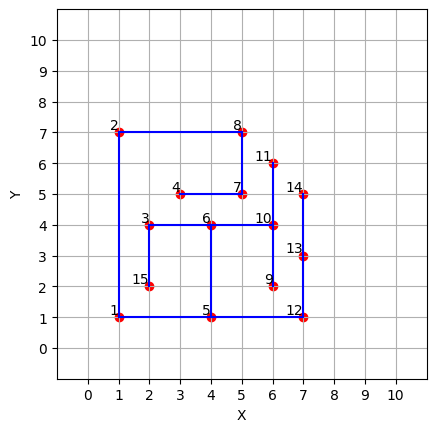

In [405]:
find_solution(graph,lines,points,vertices)

In [406]:
get_number_solution(graph,lines,points,vertices)


[[-2, -8, -15, -16, -11, -10, -3, -1], [-1, -3, -10, -11, -16, -15, -8, -2], [-5, -13, -12, -9, -4], [-4, -9, -12, -13, -5]]
Clauses: [[-7, -13], [-11, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], [1, 8, 10], [1, 8, 11], [1, 8,

[[-2, -8, -15, -16, -11, -10, -3, -1], [-1, -3, -10, -11, -16, -15, -8, -2], [-5, -13, -12, -9, -4], [-4, -9, -12, -13, -5]]
Clauses: [[-7, -13], [-11, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], [1, 8, 10], [1, 8, 11], [1, 8,

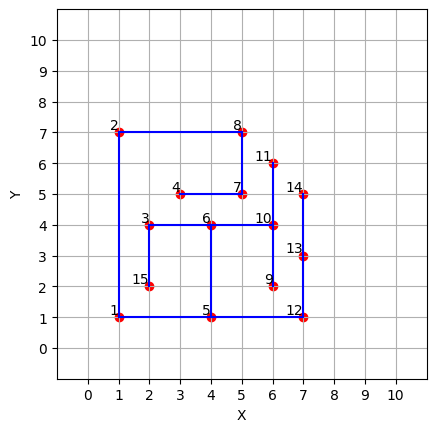

Number of solutions:  1


In [407]:
plot_all_solutions(graph,lines,points,vertices)

[[-2, -8, -15, -16, -11, -10, -3, -1], [-1, -3, -10, -11, -16, -15, -8, -2], [-5, -13, -12, -9, -4], [-4, -9, -12, -13, -5]]
Cost of the solution:  37.0


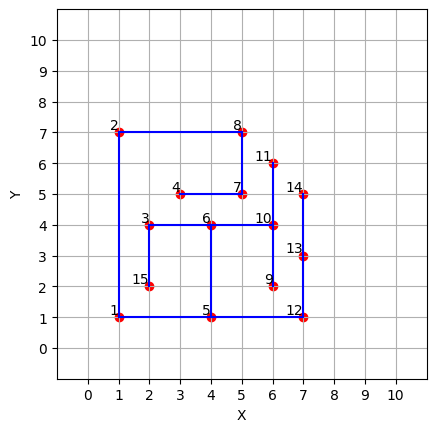

In [408]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**Cycles example**

In [409]:
p1 = Point(1,1)
p2 = Point(1,7)
p5 = Point(4,4)
p6 = Point(1,4)
p8 = Point(4,1)
p9 = Point(4,7)

points = [p1,p2,p5,p6,p8,p9]
graph,vertices,lines = initialize_graph(points)
print(lines.items())

dict_items([(1, ((1,1),(1,4))), (2, ((1,1),(4,1))), (3, ((1,7),(1,4))), (4, ((1,7),(4,7))), (5, ((4,4),(1,4))), (6, ((4,4),(4,1))), (7, ((4,4),(4,7)))])


In [410]:
all_cycles(graph)

[[1, 5, 3, 6, 2, 4, 1],
 [1, 5, 3, 4, 1],
 [1, 4, 3, 5, 1],
 [1, 4, 2, 6, 3, 5, 1],
 [2, 4, 3, 6, 2],
 [2, 6, 3, 4, 2]]

[[-2, -6, -7, -4, -3, -1], [-2, -6, -5, -1], [-1, -5, -6, -2], [-1, -3, -4, -7, -6, -2], [-3, -5, -7, -4], [-4, -7, -5, -3]]


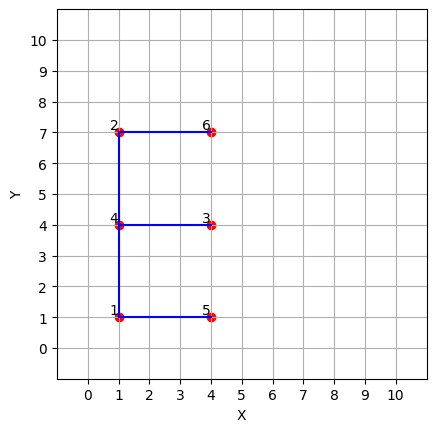

In [411]:
find_solution(graph,lines,points,vertices)

In [412]:
get_number_solution(graph,lines,points,vertices)

[[-2, -6, -7, -4, -3, -1], [-2, -6, -5, -1], [-1, -5, -6, -2], [-1, -3, -4, -7, -6, -2], [-3, -5, -7, -4], [-4, -7, -5, -3]]
Clauses: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 5, 6], [1, 5, 7], [1, 6, 7], [2, 3, 4], [2, 3, 5], [2, 3, 6], [2, 3, 7], [2, 4, 5], [2, 4, 6], [2, 4, 7], [2, 5, 6], [2, 5, 7], [2, 6, 7], [3, 4, 5], [3, 4, 6], [3, 4, 7], [3, 5, 6], [3, 5, 7], [3, 6, 7], [4, 5, 6], [4, 5, 7], [4, 6, 7], [5, 6, 7], [-1, -2, -3, -4, -5, -6], [-1, -2, -3, -4, -5, -7], [-1, -2, -3, -4, -6, -7], [-1, -2, -3, -5, -6, -7], [-1, -2, -4, -5, -6, -7], [-1, -3, -4, -5, -6, -7], [-2, -3, -4, -5, -6, -7], [-2, -6, -7, -4, -3, -1], [-2, -6, -5, -1], [-1, -5, -6, -2], [-1, -3, -4, -7, -6, -2], [-3, -5, -7, -4], [-4, -7, -5, -3]]
Number of solutions:  15


[[-2, -6, -7, -4, -3, -1], [-2, -6, -5, -1], [-1, -5, -6, -2], [-1, -3, -4, -7, -6, -2], [-3, -5, -7, -4], [-4, -7, -5, -3]]
Clauses: [[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 5, 6], [1, 5, 7], [1, 6, 7], [2, 3, 4], [2, 3, 5], [2, 3, 6], [2, 3, 7], [2, 4, 5], [2, 4, 6], [2, 4, 7], [2, 5, 6], [2, 5, 7], [2, 6, 7], [3, 4, 5], [3, 4, 6], [3, 4, 7], [3, 5, 6], [3, 5, 7], [3, 6, 7], [4, 5, 6], [4, 5, 7], [4, 6, 7], [5, 6, 7], [-1, -2, -3, -4, -5, -6], [-1, -2, -3, -4, -5, -7], [-1, -2, -3, -4, -6, -7], [-1, -2, -3, -5, -6, -7], [-1, -2, -4, -5, -6, -7], [-1, -3, -4, -5, -6, -7], [-2, -3, -4, -5, -6, -7], [-2, -6, -7, -4, -3, -1], [-2, -6, -5, -1], [-1, -5, -6, -2], [-1, -3, -4, -7, -6, -2], [-3, -5, -7, -4], [-4, -7, -5, -3]]


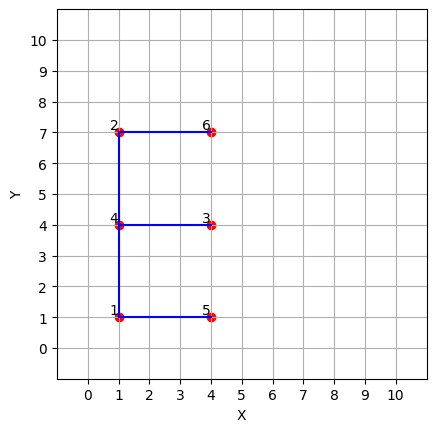

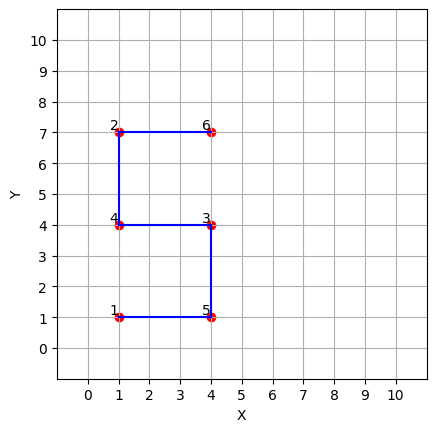

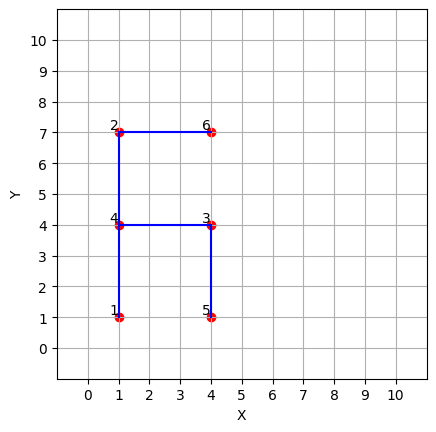

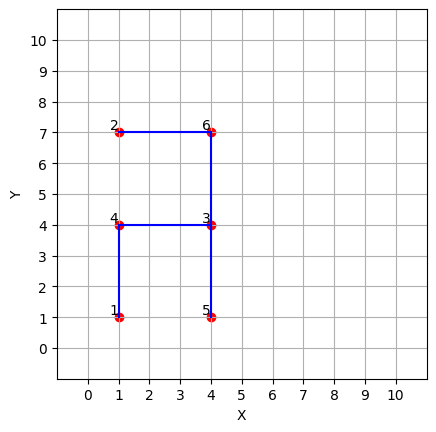

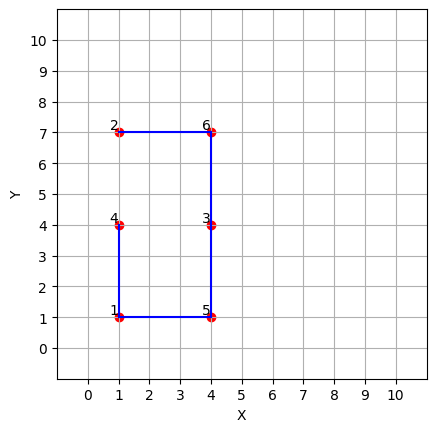

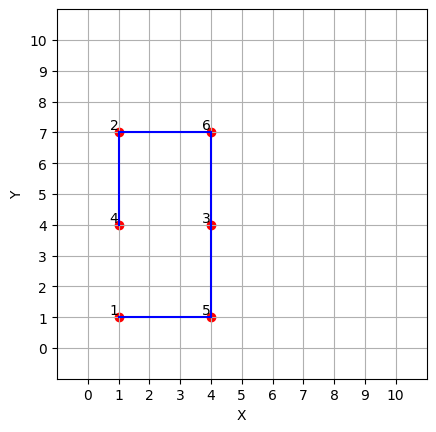

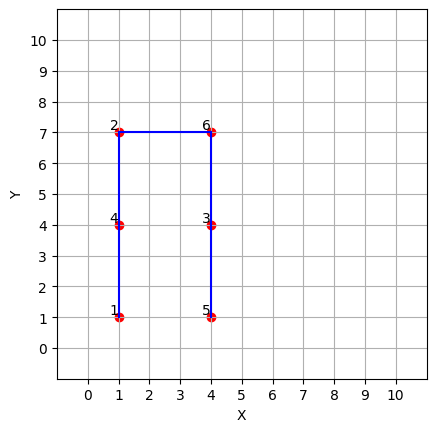

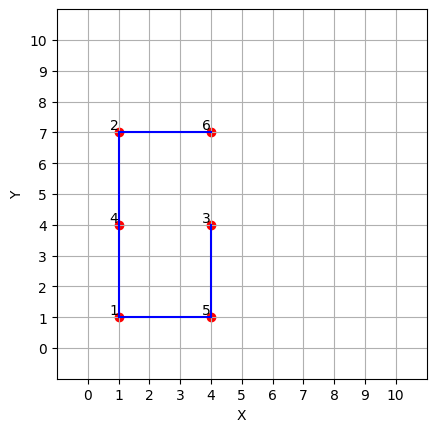

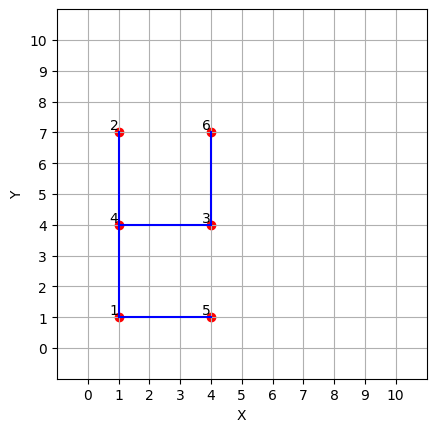

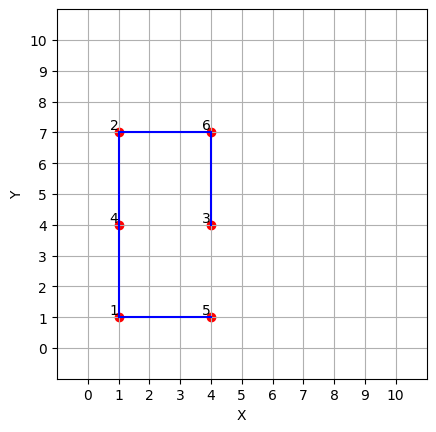

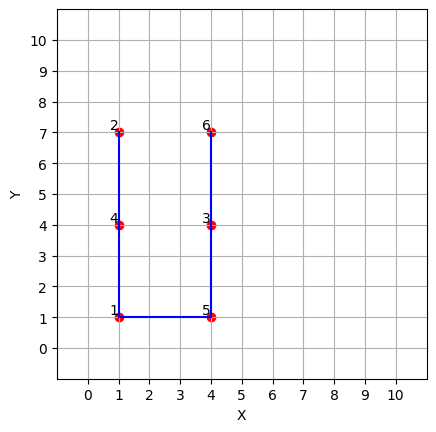

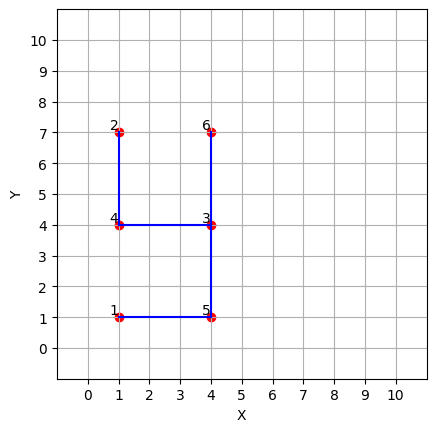

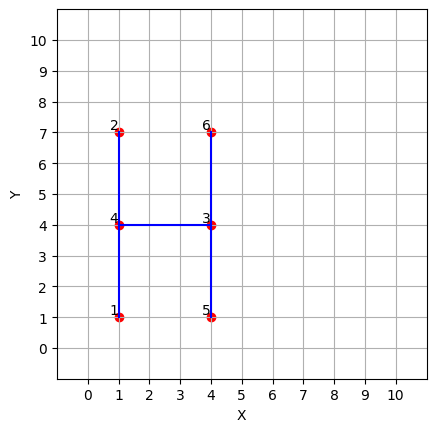

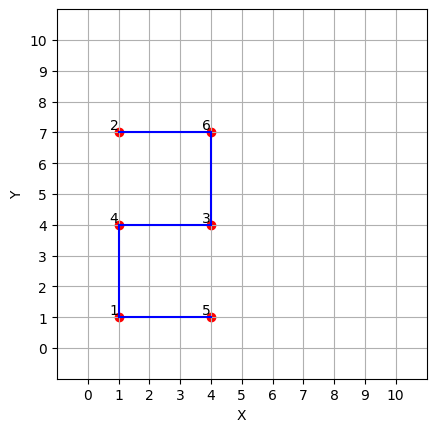

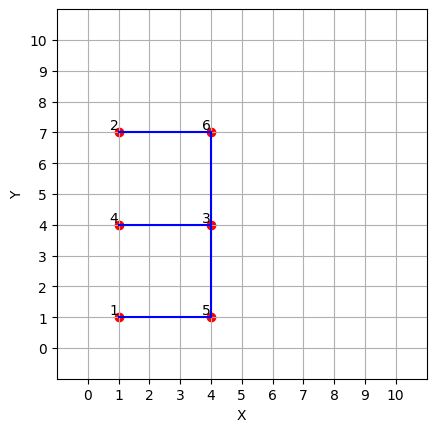

Number of solutions:  15


In [413]:
plot_all_solutions(graph,lines,points,vertices)

**Fourth example**:



In [414]:
p0 = Point(0,2)
p1=Point(0,6)
p2=Point(1,0)
p3=Point(1,4)
p4=Point(1,7)
p5=Point(2,6)
p6=Point(3,8)
p7=Point(4,0)
p8=Point(4,2)
p9=Point(4,4)
p10=Point(4,7)
p11=Point(5,5)
p12=Point(6,1)
p13=Point(7,0)
p14=Point(7,2)
p15=Point(7,5)
p16=Point(7,7)
p17=Point(8,1)
p18=Point(8,4)
p19=Point(8,8)

points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p12,p11,p13,p14,p15,p16,p17,p18,p19]
print(points)
graph,vertices,lines = initialize_graph(points)

[(0,2), (0,6), (1,0), (1,4), (1,7), (2,6), (3,8), (4,0), (4,2), (4,4), (4,7), (6,1), (5,5), (7,0), (7,2), (7,5), (7,7), (8,1), (8,4), (8,8)]


In [415]:
#all_cycles(graph)

[[-5, -10, -12, -14, -8, -6, -4], [-5, -10, -13, -20, -21, -16, -8, -6, -4], [-5, -10, -12, -7, -4], [-5, -10, -13, -20, -21, -16, -14, -7, -4], [-10, -13, -19, -11], [-6, -8, -16, -21, -20, -19, -11, -10, -12, -7], [-10, -12, -14, -16, -21, -20, -19, -11], [-4, -7, -12, -10, -5], [-4, -7, -12, -13, -19, -11, -5], [-7, -12, -13, -20, -21, -16, -8, -6], [-7, -12, -10, -11, -19, -20, -21, -16, -8, -6], [-4, -6, -8, -14, -12, -10, -5], [-4, -6, -8, -14, -12, -13, -19, -11, -5], [-13, -20, -21, -16, -14, -12], [-11, -19, -20, -21, -16, -14, -12, -10], [-5, -11, -19, -13, -12, -14, -8, -6, -4], [-5, -11, -19, -13, -12, -7, -4], [-11, -19, -13, -10], [-4, -6, -8, -16, -21, -20, -13, -10, -5], [-6, -8, -16, -21, -20, -13, -12, -7], [-4, -7, -14, -16, -21, -20, -13, -10, -5], [-12, -14, -16, -21, -20, -13], [-5, -11, -19, -20, -21, -16, -8, -6, -4], [-5, -11, -19, -20, -21, -16, -14, -7, -4], [-4, -6, -8, -16, -21, -20, -19, -11, -5], [-4, -7, -14, -16, -21, -20, -19, -11, -5], [-7, -14, -8, -

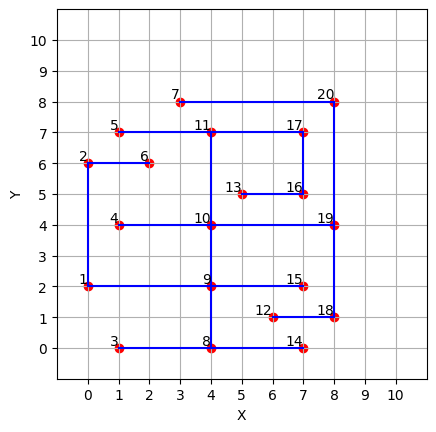

In [416]:
find_solution(graph,lines,points,vertices)

In [417]:
get_number_solution(graph,lines,points,vertices)

[[-5, -10, -12, -14, -8, -6, -4], [-5, -10, -13, -20, -21, -16, -8, -6, -4], [-5, -10, -12, -7, -4], [-5, -10, -13, -20, -21, -16, -14, -7, -4], [-10, -13, -19, -11], [-6, -8, -16, -21, -20, -19, -11, -10, -12, -7], [-10, -12, -14, -16, -21, -20, -19, -11], [-4, -7, -12, -10, -5], [-4, -7, -12, -13, -19, -11, -5], [-7, -12, -13, -20, -21, -16, -8, -6], [-7, -12, -10, -11, -19, -20, -21, -16, -8, -6], [-4, -6, -8, -14, -12, -10, -5], [-4, -6, -8, -14, -12, -13, -19, -11, -5], [-13, -20, -21, -16, -14, -12], [-11, -19, -20, -21, -16, -14, -12, -10], [-5, -11, -19, -13, -12, -14, -8, -6, -4], [-5, -11, -19, -13, -12, -7, -4], [-11, -19, -13, -10], [-4, -6, -8, -16, -21, -20, -13, -10, -5], [-6, -8, -16, -21, -20, -13, -12, -7], [-4, -7, -14, -16, -21, -20, -13, -10, -5], [-12, -14, -16, -21, -20, -13], [-5, -11, -19, -20, -21, -16, -8, -6, -4], [-5, -11, -19, -20, -21, -16, -14, -7, -4], [-4, -6, -8, -16, -21, -20, -19, -11, -5], [-4, -7, -14, -16, -21, -20, -19, -11, -5], [-7, -14, -8, -

[[-5, -10, -12, -14, -8, -6, -4], [-5, -10, -13, -20, -21, -16, -8, -6, -4], [-5, -10, -12, -7, -4], [-5, -10, -13, -20, -21, -16, -14, -7, -4], [-10, -13, -19, -11], [-6, -8, -16, -21, -20, -19, -11, -10, -12, -7], [-10, -12, -14, -16, -21, -20, -19, -11], [-4, -7, -12, -10, -5], [-4, -7, -12, -13, -19, -11, -5], [-7, -12, -13, -20, -21, -16, -8, -6], [-7, -12, -10, -11, -19, -20, -21, -16, -8, -6], [-4, -6, -8, -14, -12, -10, -5], [-4, -6, -8, -14, -12, -13, -19, -11, -5], [-13, -20, -21, -16, -14, -12], [-11, -19, -20, -21, -16, -14, -12, -10], [-5, -11, -19, -13, -12, -14, -8, -6, -4], [-5, -11, -19, -13, -12, -7, -4], [-11, -19, -13, -10], [-4, -6, -8, -16, -21, -20, -13, -10, -5], [-6, -8, -16, -21, -20, -13, -12, -7], [-4, -7, -14, -16, -21, -20, -13, -10, -5], [-12, -14, -16, -21, -20, -13], [-5, -11, -19, -20, -21, -16, -8, -6, -4], [-5, -11, -19, -20, -21, -16, -14, -7, -4], [-4, -6, -8, -16, -21, -20, -19, -11, -5], [-4, -7, -14, -16, -21, -20, -19, -11, -5], [-7, -14, -8, -

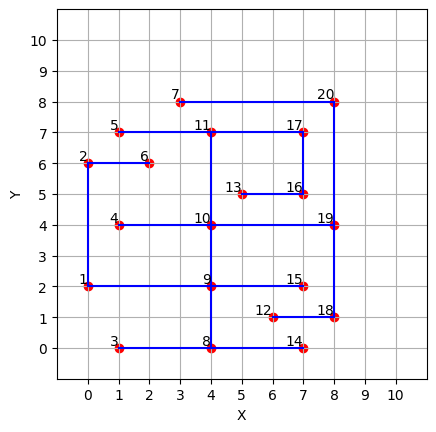

Number of solutions:  1


In [418]:
plot_all_solutions(graph,lines,points,vertices)

[[-5, -10, -12, -14, -8, -6, -4], [-5, -10, -13, -20, -21, -16, -8, -6, -4], [-5, -10, -12, -7, -4], [-5, -10, -13, -20, -21, -16, -14, -7, -4], [-10, -13, -19, -11], [-6, -8, -16, -21, -20, -19, -11, -10, -12, -7], [-10, -12, -14, -16, -21, -20, -19, -11], [-4, -7, -12, -10, -5], [-4, -7, -12, -13, -19, -11, -5], [-7, -12, -13, -20, -21, -16, -8, -6], [-7, -12, -10, -11, -19, -20, -21, -16, -8, -6], [-4, -6, -8, -14, -12, -10, -5], [-4, -6, -8, -14, -12, -13, -19, -11, -5], [-13, -20, -21, -16, -14, -12], [-11, -19, -20, -21, -16, -14, -12, -10], [-5, -11, -19, -13, -12, -14, -8, -6, -4], [-5, -11, -19, -13, -12, -7, -4], [-11, -19, -13, -10], [-4, -6, -8, -16, -21, -20, -13, -10, -5], [-6, -8, -16, -21, -20, -13, -12, -7], [-4, -7, -14, -16, -21, -20, -13, -10, -5], [-12, -14, -16, -21, -20, -13], [-5, -11, -19, -20, -21, -16, -8, -6, -4], [-5, -11, -19, -20, -21, -16, -14, -7, -4], [-4, -6, -8, -16, -21, -20, -19, -11, -5], [-4, -7, -14, -16, -21, -20, -19, -11, -5], [-7, -14, -8, -

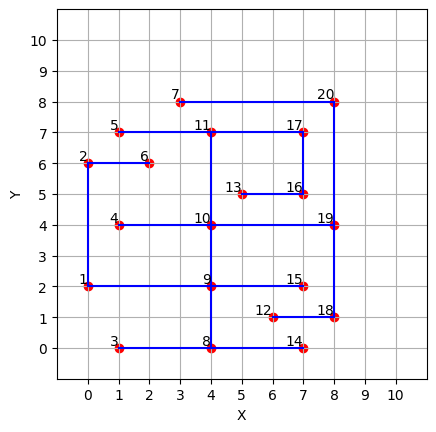

In [419]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**10x10**



In [420]:
p0 = Point(0,2)
p1=Point(0,5)
p2=Point(1,0)
p3=Point(1,4)
p4=Point(1,7)
p5=Point(1,9)
p6=Point(2,1)
p7=Point(2,5)
p8=Point(3,2)
p9=Point(3,4)
p10=Point(4,1)
p11=Point(5,9)
p12=Point(5,0)
p13=Point(5,2)
p14=Point(5,5)
p15=Point(5,7)
p16=Point(6,9)
p17=Point(7,0)
p18=Point(7,7)
p19=Point(8,2)
p20=Point(8,4)
p21=Point(8,9)
p22=Point(9,3)
p23=Point(9,5)
p24=Point(9,8)

points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p12,p11,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24]
print(points)
graph,vertices,lines = initialize_graph(points)

[(0,2), (0,5), (1,0), (1,4), (1,7), (1,9), (2,1), (2,5), (3,2), (3,4), (4,1), (5,0), (5,9), (5,2), (5,5), (5,7), (6,9), (7,0), (7,7), (8,2), (8,4), (8,9), (9,3), (9,5), (9,8)]


[[-2, -15, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -10, -8, -6, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -19, -9, -6, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -7, -6, -9, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -10, -8, -9, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -7, -6, -8, -10, -19, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -19, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -6, -8, -10, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -18, -27, -25, -9, -8, -10, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -6, -9, -19, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -18, -27, -25, -19, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -15, -17, -5, -4, -6, -9, -23, -13, -3, -1], [-2, -14, -16, -28, -22, -17, -5, -4, -6, -9, -23, -13, -3, -1], [-2, 

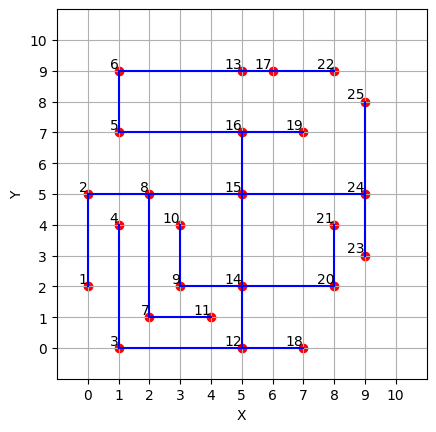

In [421]:
find_solution(graph,lines,points,vertices)

In [422]:
get_number_solution(graph,lines,points,vertices)

[[-2, -15, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -10, -8, -6, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -19, -9, -6, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -17, -21, -13, -3, -1], [-2, -14, -7, -6, -9, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -10, -8, -9, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -7, -6, -8, -10, -19, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -29, -26, -20, -19, -25, -27, -18, -17, -21, -13, -3, -1], [-2, -14, -16, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -6, -8, -10, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -18, -27, -25, -9, -8, -10, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -6, -9, -19, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -14, -7, -4, -5, -18, -27, -25, -19, -20, -26, -29, -28, -22, -21, -13, -3, -1], [-2, -15, -17, -5, -4, -6, -9, -23, -13, -3, -1], [-2, -14, -16, -28, -22, -17, -5, -4, -6, -9, -23, -13, -3, -1], [-2, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



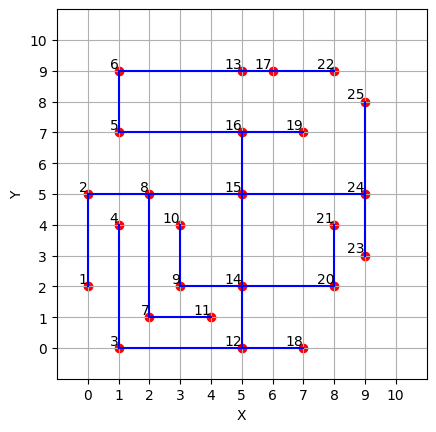

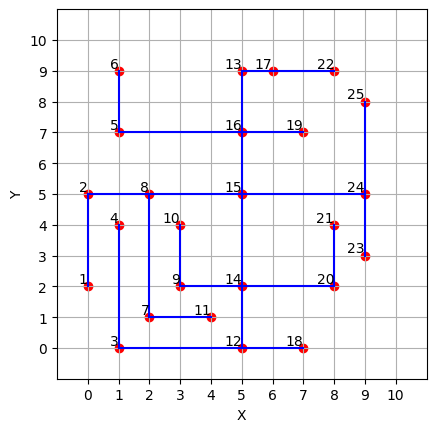

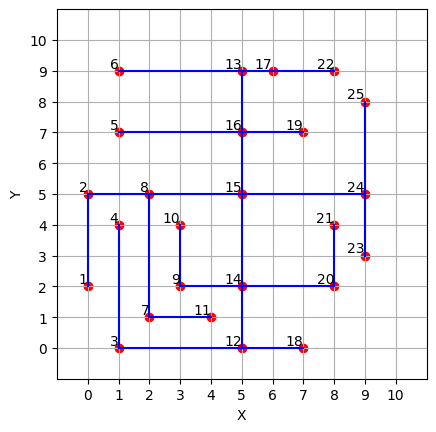

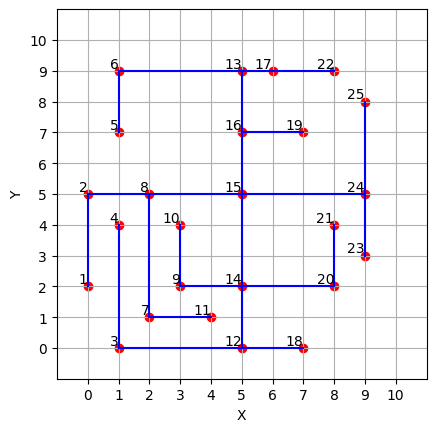

Number of solutions:  4


In [423]:
plot_all_solutions(graph,lines,points,vertices)

# Broken Example

**10x10 with 12 nodes**

In [454]:
p0 = Point(2,1)
p1=Point(6,1)
p2=Point(8,1)
p3=Point(0,7)
p4=Point(2,7)
p5=Point(4,7)
p6=Point(6,5)
p7=Point(6,7)
p8=Point(6,9)
p9=Point(8,1)
p10=Point(8,9)
p11=Point(9,5)
p12=Point(9,7)

points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12]
print(points)
graph,vertices,lines = initialize_graph(points)

[(2,1), (6,1), (8,1), (0,7), (2,7), (4,7), (6,5), (6,7), (6,9), (8,1), (8,9), (9,5), (9,7)]


In [455]:
all_cycles(graph)

[[1, 2, 3, 11, 9, 8, 6, 5, 1],
 [1, 2, 7, 8, 6, 5, 1],
 [1, 2, 7, 12, 13, 8, 6, 5, 1],
 [1, 2, 10, 11, 9, 8, 6, 5, 1],
 [1, 5, 6, 8, 7, 2, 1],
 [1, 5, 6, 8, 9, 11, 3, 2, 1],
 [1, 5, 6, 8, 9, 11, 10, 2, 1],
 [1, 5, 6, 8, 13, 12, 7, 2, 1],
 [2, 1, 5, 6, 8, 7, 2],
 [2, 1, 5, 6, 8, 9, 11, 3, 2],
 [2, 1, 5, 6, 8, 9, 11, 10, 2],
 [2, 1, 5, 6, 8, 13, 12, 7, 2],
 [2, 3, 11, 9, 8, 6, 5, 1, 2],
 [2, 3, 11, 9, 8, 7, 2],
 [2, 3, 11, 9, 8, 13, 12, 7, 2],
 [2, 3, 11, 10, 2],
 [2, 7, 8, 6, 5, 1, 2],
 [2, 7, 8, 9, 11, 3, 2],
 [2, 7, 8, 9, 11, 10, 2],
 [2, 7, 12, 13, 8, 6, 5, 1, 2],
 [2, 7, 12, 13, 8, 9, 11, 3, 2],
 [2, 7, 12, 13, 8, 9, 11, 10, 2],
 [2, 10, 11, 3, 2],
 [2, 10, 11, 9, 8, 6, 5, 1, 2],
 [2, 10, 11, 9, 8, 7, 2],
 [2, 10, 11, 9, 8, 13, 12, 7, 2],
 [1, 2, 3, 11, 9, 8, 6, 5, 1],
 [1, 2, 7, 8, 6, 5, 1],
 [1, 2, 7, 12, 13, 8, 6, 5, 1],
 [1, 2, 10, 11, 9, 8, 6, 5, 1],
 [1, 5, 6, 8, 7, 2, 1],
 [1, 5, 6, 8, 9, 11, 3, 2, 1],
 [1, 5, 6, 8, 9, 11, 10, 2, 1],
 [1, 5, 6, 8, 13, 12, 7, 2, 1],
 [5, 1, 2,

[[-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9, -10, -4, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -13, -16, -11, -4, -1], [-1, -2, -8, -9, -10, -4], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -13, -16, -11, -4], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-3, -6, -6, -3], [-4, -10, -9, -8, -2, -1], [-4, -10, -12, -14, -6, -3], [-4, -10, -12, -14, -6, -3], [-4, -11, -16, -13, -9, -8, -2, -1], [-4, -11, -16, -13, -12, -14, -6, -3], [-4, -11, -16, -13, -12, -14, -6, -3], [-3, -6, -6, -3], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9

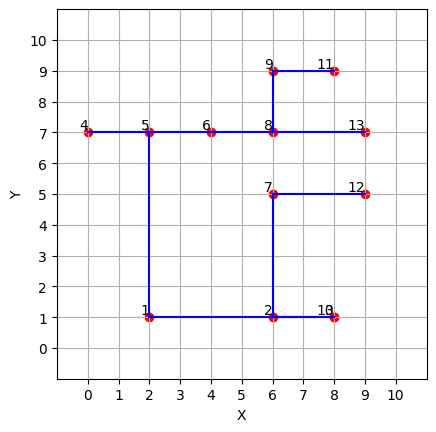

In [456]:
find_solution(graph,lines,points,vertices)

In [457]:
get_number_solution(graph,lines,points,vertices)

[[-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9, -10, -4, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -13, -16, -11, -4, -1], [-1, -2, -8, -9, -10, -4], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -13, -16, -11, -4], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-3, -6, -6, -3], [-4, -10, -9, -8, -2, -1], [-4, -10, -12, -14, -6, -3], [-4, -10, -12, -14, -6, -3], [-4, -11, -16, -13, -9, -8, -2, -1], [-4, -11, -16, -13, -12, -14, -6, -3], [-4, -11, -16, -13, -12, -14, -6, -3], [-3, -6, -6, -3], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9

[[-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9, -10, -4, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -13, -16, -11, -4, -1], [-1, -2, -8, -9, -10, -4], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -13, -16, -11, -4], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-3, -6, -6, -3], [-4, -10, -9, -8, -2, -1], [-4, -10, -12, -14, -6, -3], [-4, -10, -12, -14, -6, -3], [-4, -11, -16, -13, -9, -8, -2, -1], [-4, -11, -16, -13, -12, -14, -6, -3], [-4, -11, -16, -13, -12, -14, -6, -3], [-3, -6, -6, -3], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9

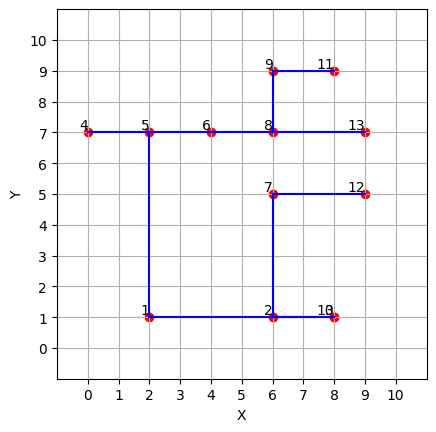

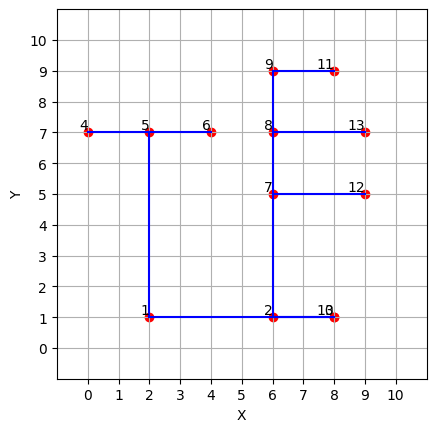

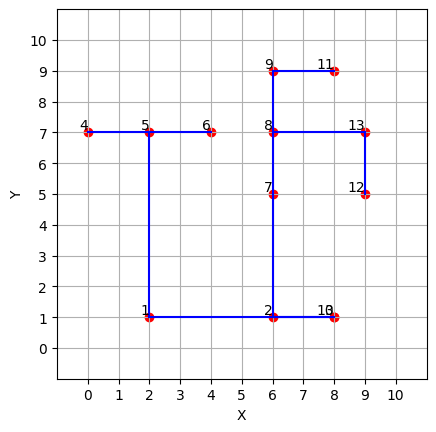

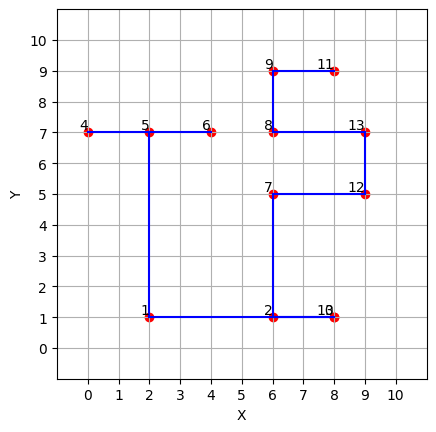

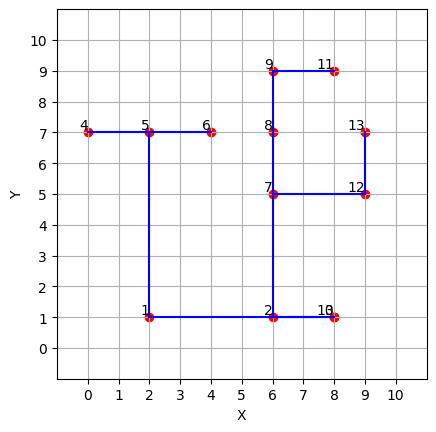

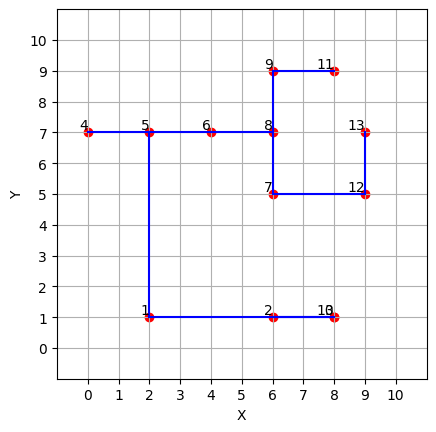

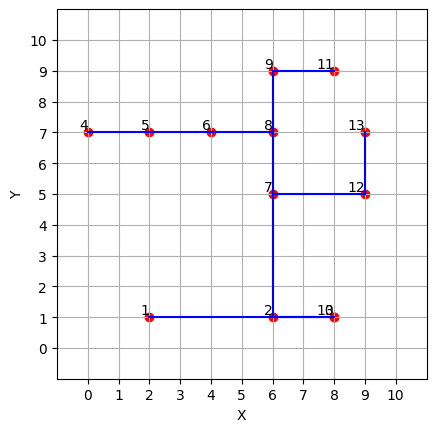

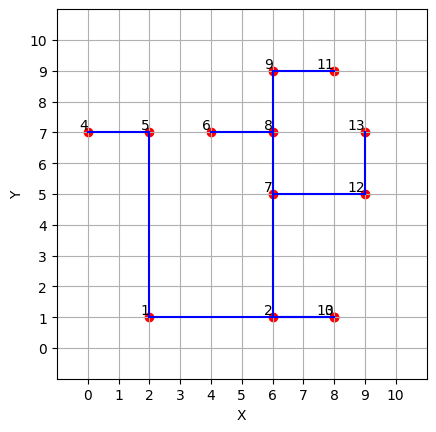

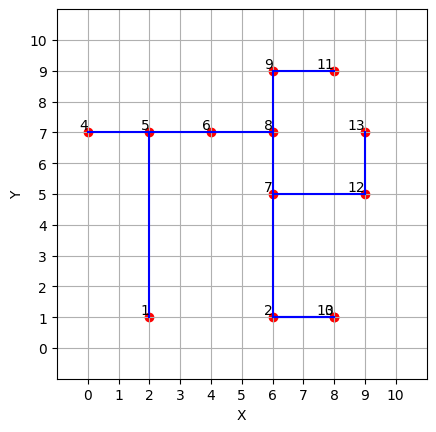

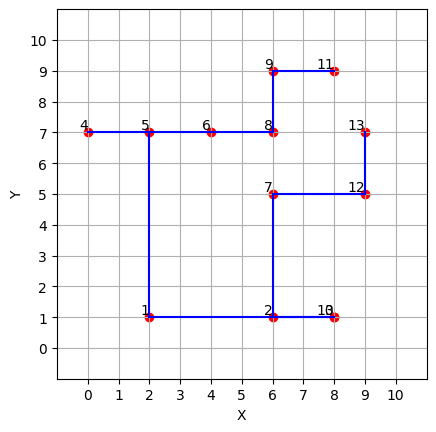

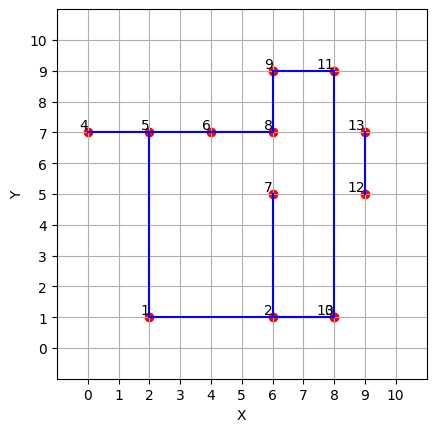

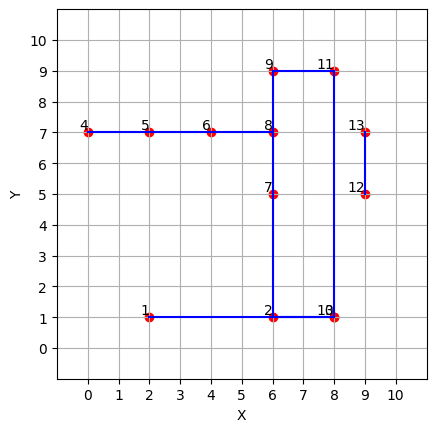

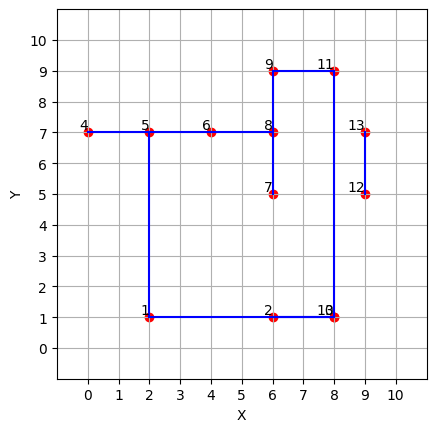

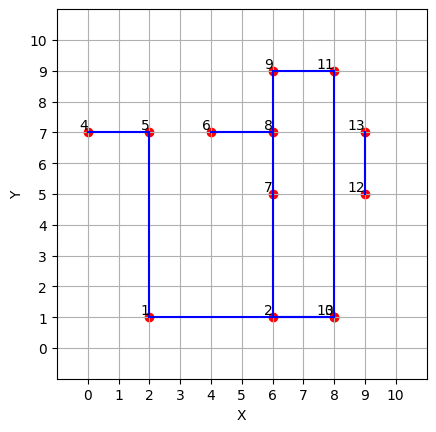

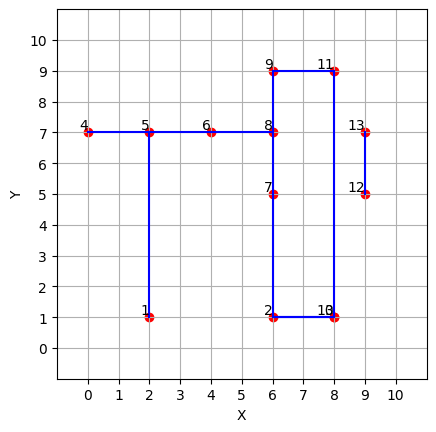

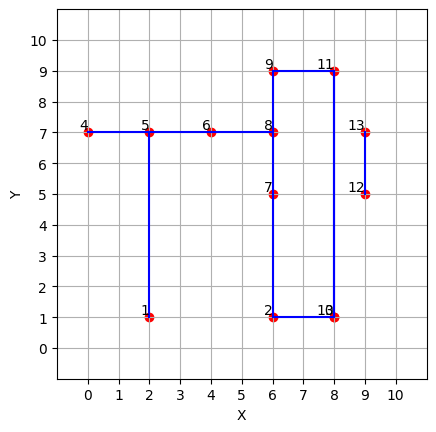

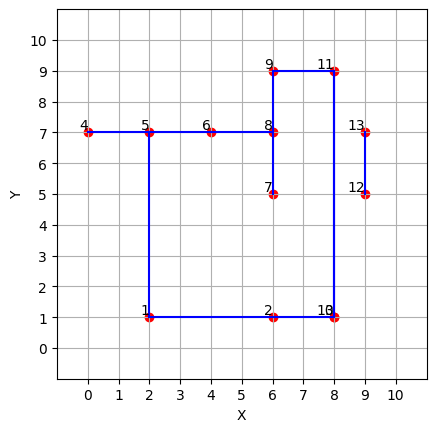

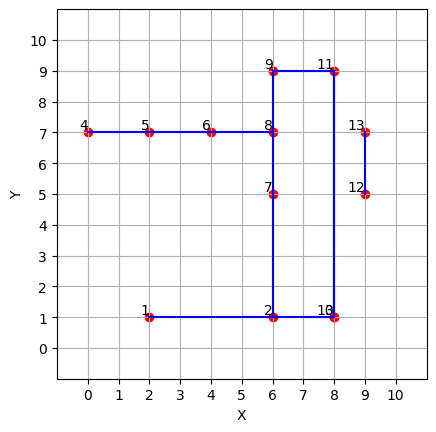

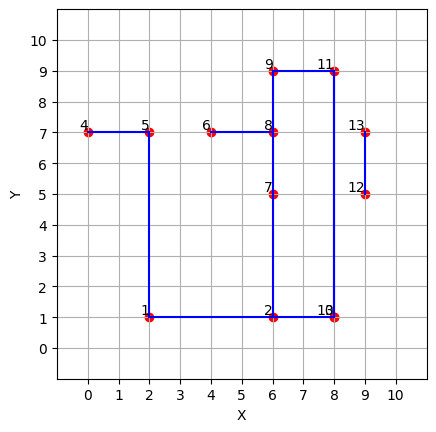

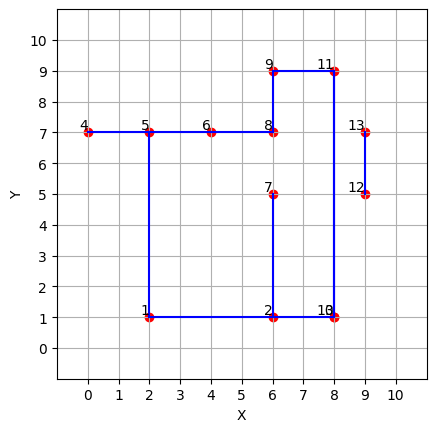

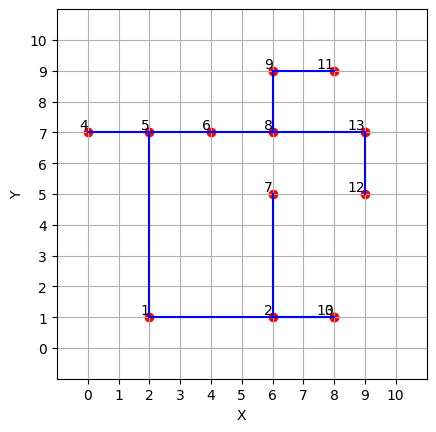

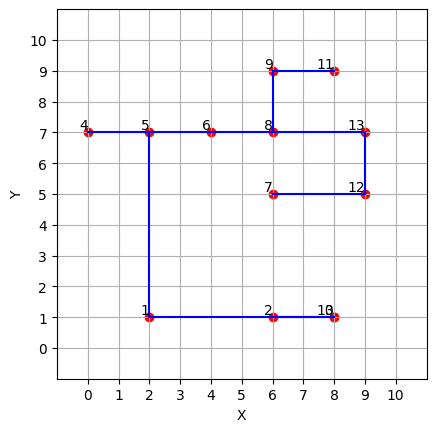

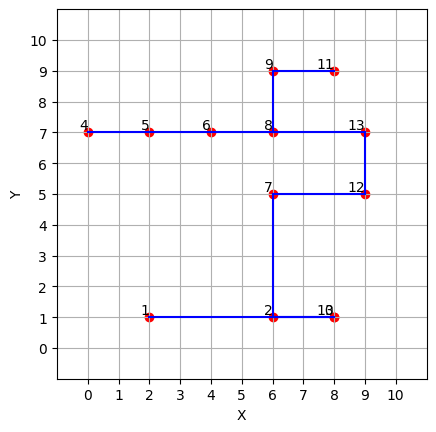

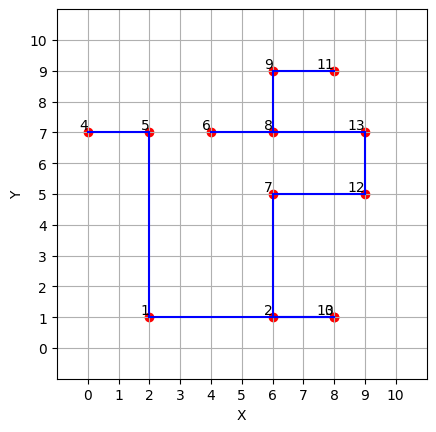

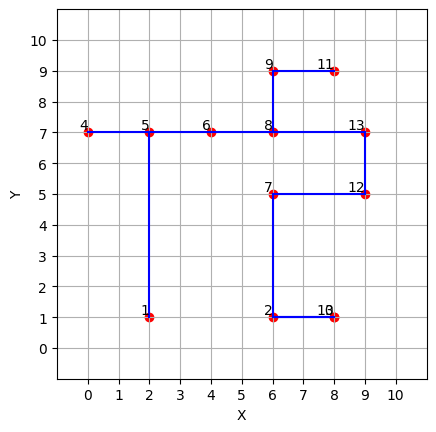

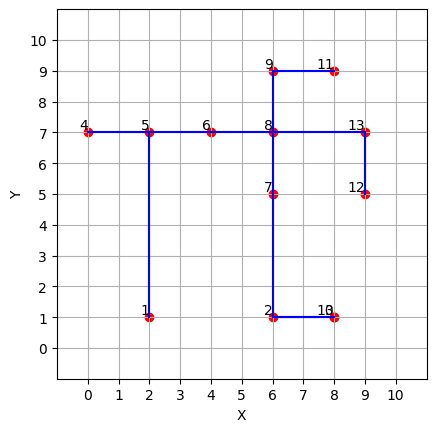

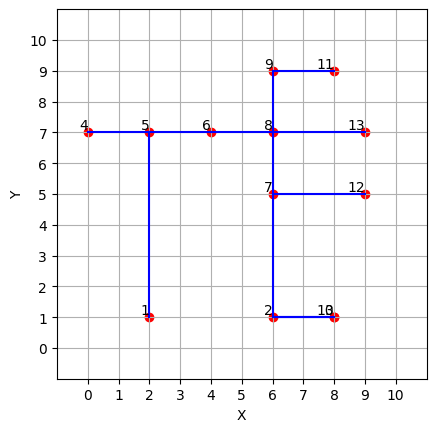

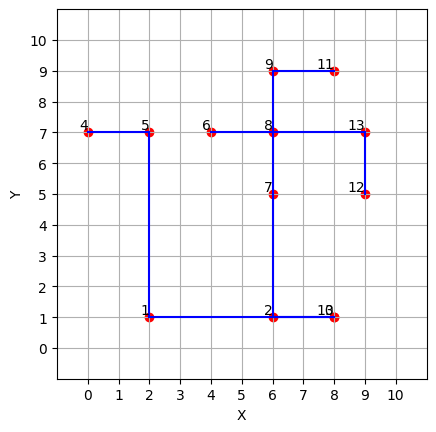

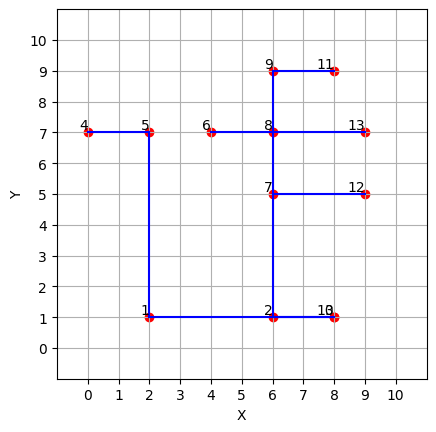

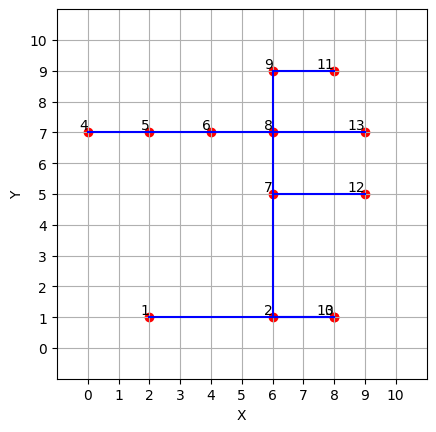

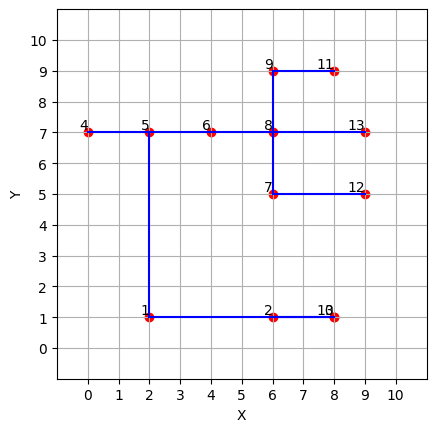

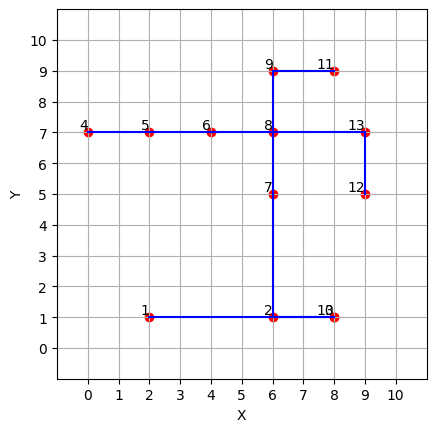

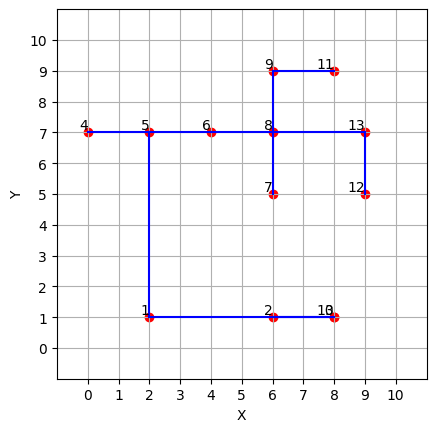

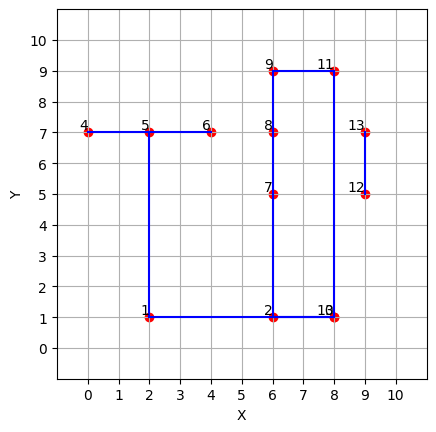

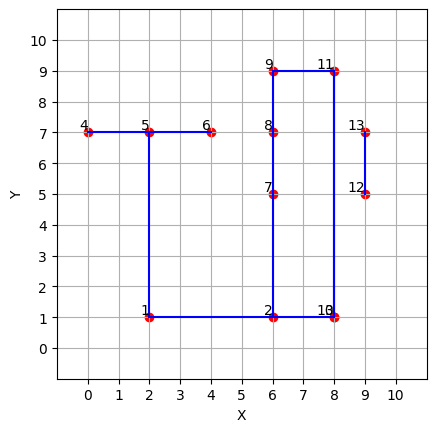

Number of solutions:  35


In [458]:
plot_all_solutions(graph,lines,points,vertices)

[[-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9, -10, -4, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -12, -14, -6, -3, -1], [-2, -8, -9, -13, -16, -11, -4, -1], [-1, -2, -8, -9, -10, -4], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -12, -14, -6, -3], [-1, -2, -8, -9, -13, -16, -11, -4], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-3, -6, -6, -3], [-4, -10, -9, -8, -2, -1], [-4, -10, -12, -14, -6, -3], [-4, -10, -12, -14, -6, -3], [-4, -11, -16, -13, -9, -8, -2, -1], [-4, -11, -16, -13, -12, -14, -6, -3], [-4, -11, -16, -13, -12, -14, -6, -3], [-3, -6, -6, -3], [-3, -6, -14, -12, -9, -8, -2, -1], [-3, -6, -14, -12, -10, -4], [-3, -6, -14, -12, -13, -16, -11, -4], [-1, -3, -6, -14, -12, -9, -8, -2], [-1, -4, -10, -9, -8, -2], [-1, -4, -11, -16, -13, -9, -8, -2], [-1, -3, -6, -14, -12, -9, -8, -2], [-2, -8, -9

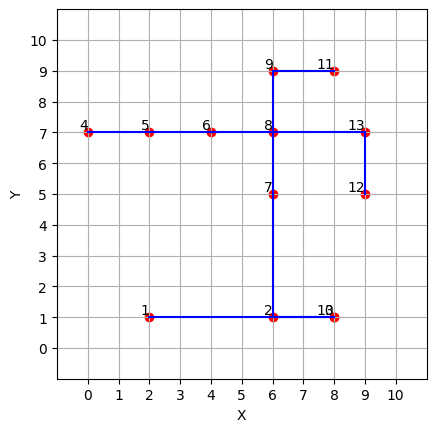

In [459]:
get_minimum_lenght_solution(graph,lines,points,vertices)